Using device: mps
Training data length   = 1000 hours
Validation data length = 1000 hours
Episode 1/8 | Reward=0.2062 | TrainLoss=0.000208 | ValLoss=0.000034 | ε=0.900
Episode 2/8 | Reward=0.1986 | TrainLoss=0.000019 | ValLoss=0.000035 | ε=0.712
Episode 3/8 | Reward=0.3100 | TrainLoss=0.000014 | ValLoss=0.000031 | ε=0.566
Episode 4/8 | Reward=0.2012 | TrainLoss=0.000012 | ValLoss=0.000029 | ε=0.452
Episode 5/8 | Reward=0.2751 | TrainLoss=0.000009 | ValLoss=0.000023 | ε=0.363
Episode 6/8 | Reward=0.5671 | TrainLoss=0.000008 | ValLoss=0.000027 | ε=0.294
Episode 7/8 | Reward=0.8444 | TrainLoss=0.000007 | ValLoss=0.000025 | ε=0.240
Episode 8/8 | Reward=1.1503 | TrainLoss=0.000006 | ValLoss=0.000031 | ε=0.198


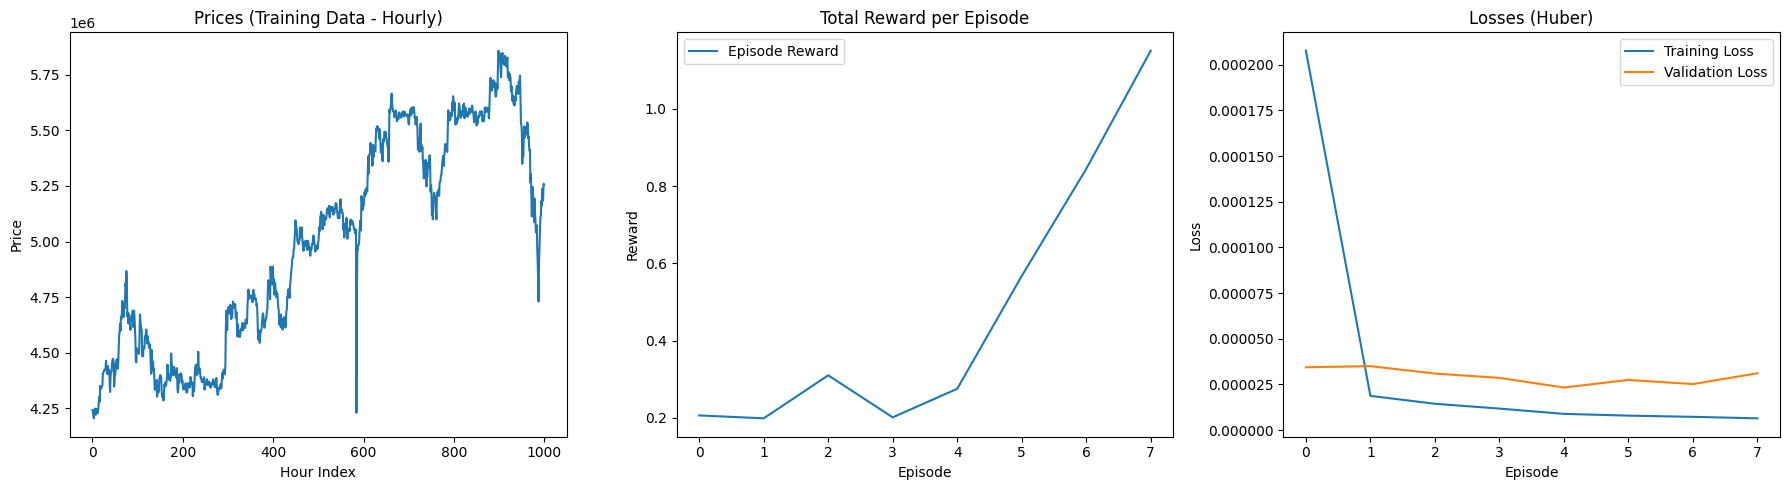


----- Validation Results (Hourly) -----
 Starting Balance: 5,000,000.00 KRW
 Final Balance:    4,956,579.89 KRW
 Total PnL:        -43,420.11 KRW (-0.87%)


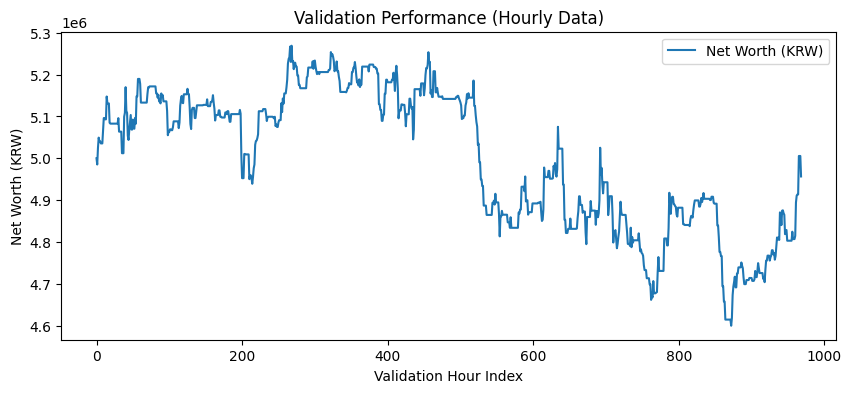

In [25]:
# 3.2-->3.2.1 
'''
1. Use a smaller learning rate: 0.005 is quite high for neural-network-based RL on noisy data.
2. Lower weight decay: Excessive weight decay can hamper learning.
3. Adopt Double DQN: Addresses maximization bias by using the online network to select the best action and the target network to estimate the value.
4. Soft-update the target network (Polyak averaging) each step instead of a hard copy every episode.
5. Use Huber loss instead of MSE for better gradient behavior on outliers.
6. Train for more episodes (or steps). DQN can require thousands of episodes in some domains, although your dataset length also matters.
7. Clip large rewards or scale them to stabilize training. (Optional – depends on your data’s magnitude.)
8. Optional: Add transaction costs, partial buys/sells, or more features (volume, momentum indicators, etc.) for realism.
'''

import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Device selection
device = torch.device(
    "cuda" if torch.cuda.is_available() else 
    "mps" if torch.backends.mps.is_available() else 
    "cpu"
)
print(f"Using device: {device}")

def fetch_historical_data(quote="KRW", target="ETH", hours=5000):
    base_url = f"https://api.bithumb.com/public/candlestick/{target}_{quote}/1h"
    
    try:
        response = requests.get(base_url, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        if data.get("status") != "0000":
            print(f"API Error: {data.get('message', 'Unknown error')}")
            return None
            
        candlesticks = data.get("data", [])
        if not candlesticks:
            print("No hourly data found in response.")
            return None
            
        prices = [float(entry[2]) for entry in candlesticks[-hours:]]
        return np.array(prices, dtype=np.float32)
        
    except Exception as e:
        print(f"Error fetching hourly data: {str(e)}")
        return None

class EnhancedTradingEnv:
    def __init__(self, prices, window_size=30, initial_balance=1000000.0):
        self.prices = prices
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.reset()
        
    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position = 0.0
        self.net_worth = [self.initial_balance] * self.window_size
        return self._get_observation()
    
    def _get_observation(self):
        price_window = self.prices[self.current_step - self.window_size : self.current_step]
        
        mean_p = np.mean(price_window)
        std_p = np.std(price_window) if np.std(price_window) > 0 else 1.0
        normalized_prices = (price_window - mean_p) / std_p
        
        returns = np.diff(price_window) / price_window[:-1] if len(price_window) > 1 else [0]
        volatility = np.std(returns) if len(returns) > 1 else 0.0
        
        return np.concatenate([
            normalized_prices,
            [
                self.balance / self.initial_balance,
                self.position,
                volatility
            ]
        ]).astype(np.float32)
    
    def step(self, action):
        current_price = self.prices[self.current_step]

        # ✅ Fix: Prevent multiple consecutive buys
        if action == 1 and self.position > 0:  
            action = 0  # Force "Hold" if already in position

        # ✅ Fix: Prevent consecutive sells when not holding any position
        if action == 2 and self.position == 0:
            action = 0  # Force "Hold" if no position

        if action == 1:  # Buy
            max_buy = self.balance / current_price
            self.position += max_buy
            self.balance -= max_buy * current_price

        elif action == 2:  # Sell
            self.balance += self.position * current_price
            self.position = 0.0  # Reset position to 0

        # Update net worth
        current_net_worth = self.balance + self.position * current_price
        self.net_worth.append(current_net_worth)

        # Reward = log change in net worth
        prev_worth = self.net_worth[-2]
        reward = 0.0 if prev_worth <= 0 else np.log(current_net_worth / prev_worth)

        self.current_step += 1
        done = (self.current_step >= len(self.prices) - 1)

        return self._get_observation(), reward, done



class CNN_DQN(nn.Module):
    def __init__(self, window_size, num_actions):
        super(CNN_DQN, self).__init__()
        self.window_size = window_size

        # 1D CNN feature extractor
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        conv_out_size = self._conv_out(window_size)

        # Fully-connected layers
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size + 3, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_actions)
        )

    def _conv_out(self, size):
        with torch.no_grad():
            o = self.conv(torch.zeros(1, 1, size))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        batch_size = x.size(0)
        prices = x[:, :self.window_size]
        extra = x[:, self.window_size:]
        
        conv_input = prices.unsqueeze(1)
        conv_output = self.conv(conv_input)
        conv_flat = conv_output.view(batch_size, -1)
        
        combined = torch.cat([conv_flat, extra], dim=1)
        q_values = self.fc(combined)
        return q_values

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

def compute_validation_loss(model, target_net, prices, window_size, initial_balance, gamma=0.99, batch_size=64):
    """
    Runs a single 'episode' in a validation environment (greedy policy),
    gathers transitions, computes average Huber loss vs. the target network.
    """
    env = EnhancedTradingEnv(prices=prices, window_size=window_size, initial_balance=initial_balance)
    state = env.reset()
    done = False
    transitions = []
    
    while not done:
        with torch.no_grad():
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = model(state_t).argmax(dim=1).item()
        next_state, reward, done = env.step(action)
        transitions.append((state, action, reward, next_state, done))
        state = next_state
    
    total_loss = 0.0
    count = 0
    huber = nn.SmoothL1Loss()

    with torch.no_grad():
        for i in range(0, len(transitions), batch_size):
            batch = transitions[i:i+batch_size]
            states, actions_b, rewards_b, next_states_b, dones_b = zip(*batch)
            
            states_t = torch.FloatTensor(states).to(device)
            actions_t = torch.LongTensor(actions_b).to(device)
            rewards_t = torch.FloatTensor(rewards_b).to(device)
            next_states_t = torch.FloatTensor(next_states_b).to(device)
            dones_t = torch.BoolTensor(dones_b).to(device)
            
            current_q = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)
            
            # Double DQN style target:
            # 1) actions from online network
            online_actions = model(next_states_t).argmax(dim=1, keepdim=True)
            # 2) q-values from target network, choose the above actions
            next_q = target_net(next_states_t).gather(1, online_actions).squeeze(1)
            
            target_q = rewards_t + gamma * next_q * (~dones_t)
            loss = huber(current_q, target_q)
            
            total_loss += loss.item() * len(batch)
            count += len(batch)

    avg_val_loss = total_loss / count if count > 0 else 0.0
    return avg_val_loss

def validate_model(model, prices, window_size=30, initial_balance=10000.0):
    env = EnhancedTradingEnv(prices=prices, window_size=window_size, initial_balance=initial_balance)
    state = env.reset()
    
    done = False
    prev_net_worth = env.net_worth[-1]
    hourly_records = []
    
    while not done:
        with torch.no_grad():
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = model(state_t).argmax(dim=1).item()
        
        next_state, _, done = env.step(action)
        current_net_worth = env.net_worth[-1]
        
        hourly_pnl = current_net_worth - prev_net_worth
        hourly_records.append({
            "hour_index": env.current_step,
            "action": action,
            "net_worth": current_net_worth,
            "hourly_pnl": hourly_pnl
        })
        
        prev_net_worth = current_net_worth
        state = next_state
    
    final_balance = env.net_worth[-1]
    total_pnl = final_balance - initial_balance
    pct_return = (total_pnl / initial_balance) * 100.0
    
    print("\n----- Validation Results (Hourly) -----")
    print(f" Starting Balance: {initial_balance:,.2f} KRW")
    print(f" Final Balance:    {final_balance:,.2f} KRW")
    print(f" Total PnL:        {total_pnl:,.2f} KRW ({pct_return:.2f}%)")
    
    return hourly_records

def plot_training_progress(episode_rewards, prices, training_losses, validation_losses):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    axs[0].plot(prices)
    axs[0].set_title("Prices (Training Data - Hourly)")
    axs[0].set_xlabel("Hour Index")
    axs[0].set_ylabel("Price")
    
    axs[1].plot(episode_rewards, label="Episode Reward")
    axs[1].set_title("Total Reward per Episode")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Reward")
    axs[1].legend()
    
    axs[2].plot(training_losses, label="Training Loss")
    axs[2].plot(validation_losses, label="Validation Loss")
    axs[2].set_title("Losses (Huber)")
    axs[2].set_xlabel("Episode")
    axs[2].set_ylabel("Loss")
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 1) Fetch data
    coin = "ETH"
    quote = "KRW"
    total_hours = 2000
    all_prices = fetch_historical_data(quote=quote, target=coin, hours=total_hours)
    
    if all_prices is None or len(all_prices) < total_hours:
        print("Failed to fetch enough hourly data.")
        exit(1)
        
    # 2) Split data
    split_index = len(all_prices) // 2
    training_prices   = all_prices[:split_index]
    validation_prices = all_prices[split_index:]
    
    print(f"Training data length   = {len(training_prices)} hours")
    print(f"Validation data length = {len(validation_prices)} hours")
    
    # 3) Environment
    env = EnhancedTradingEnv(prices=training_prices, window_size=30, initial_balance=10000)
    state_size = len(env._get_observation())
    num_actions = 3
    
    # 4) Initialize model and target network
    model = CNN_DQN(window_size=30, num_actions=num_actions).to(device)
    target_net = CNN_DQN(window_size=30, num_actions=num_actions).to(device)
    target_net.load_state_dict(model.state_dict())
    target_net.eval()
    
    # 5) Training hyperparams
    # Lower LR and weight decay
    optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-1)
    replay_buffer = ReplayBuffer(capacity=20000)
    
    batch_size = 64
    gamma = 0.99
    
    # Epsilon parameters
    epsilon_start = 0.9
    epsilon_end = 0.05
    epsilon_decay = 4  # can tweak
    
    # Soft update rate
    tau = 0.01  # can tweak
    
    episodes = 8  # increase episodes to see better learning
    max_steps_per_episode = 2000  # in case data is large

    # Logging lists
    episode_rewards = []
    training_losses = []
    validation_losses = []
    
    huber_loss_fn = nn.SmoothL1Loss()
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0.0
        episode_loss = 0.0
        training_steps = 0
        
        # Epsilon decay
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1.0 * episode / epsilon_decay)
        
        for step_i in range(max_steps_per_episode):
            # Epsilon-greedy
            if random.random() > epsilon:
                with torch.no_grad():
                    state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = model(state_t).argmax(dim=1).item()
            else:
                action = random.randint(0, num_actions - 1)
            
            next_state, reward, done = env.step(action)
            total_reward += reward
            
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            
            # Update if enough samples
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states_b, actions_b, rewards_b, next_states_b, dones_b = zip(*batch)
                
                states_t = torch.FloatTensor(states_b).to(device)
                actions_t = torch.LongTensor(actions_b).to(device)
                rewards_t = torch.FloatTensor(rewards_b).to(device)
                next_states_t = torch.FloatTensor(next_states_b).to(device)
                dones_t = torch.BoolTensor(dones_b).to(device)
                
                # Current Q
                current_q = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)
                
                # Double DQN target
                with torch.no_grad():
                    # a') – actions selected by the current (online) network
                    online_actions = model(next_states_t).argmax(dim=1, keepdim=True)
                    # Q(s', a') – target network evaluation
                    next_q = target_net(next_states_t).gather(1, online_actions).squeeze(1)
                    
                    target_q = rewards_t + gamma * next_q * (~dones_t)
                
                loss = huber_loss_fn(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                # Gradient clipping can help
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                episode_loss += loss.item()
                training_steps += 1
            
            # Soft update the target network
            with torch.no_grad():
                for param, target_param in zip(model.parameters(), target_net.parameters()):
                    target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
            
            if done:
                break
        
        # Episode stats
        episode_rewards.append(total_reward)
        avg_train_loss = episode_loss / (training_steps if training_steps > 0 else 1.0)
        training_losses.append(avg_train_loss)
        
        # Validation loss
        val_loss = compute_validation_loss(
            model=model, 
            target_net=target_net, 
            prices=validation_prices, 
            window_size=30, 
            initial_balance=10000.0,
            gamma=gamma,
            batch_size=batch_size
        )
        validation_losses.append(val_loss)
        
        print(f"Episode {episode+1}/{episodes} | "
              f"Reward={total_reward:.4f} | "
              f"TrainLoss={avg_train_loss:.6f} | "
              f"ValLoss={val_loss:.6f} | "
              f"ε={epsilon:.3f}")

    # Plot the training progress
    plot_training_progress(episode_rewards, training_prices, training_losses, validation_losses)
    
    # Final validation run
    validation_start_balance = 5_000_000.0
    validation_data = validate_model(
        model,
        prices=validation_prices, 
        window_size=30, 
        initial_balance=validation_start_balance
    )
    
    # Plot net worth
    networth_vals = [r["net_worth"] for r in validation_data]
    plt.figure(figsize=(10, 4))
    plt.plot(networth_vals, label="Net Worth (KRW)")
    plt.title("Validation Performance (Hourly Data)")
    plt.xlabel("Validation Hour Index")
    plt.ylabel("Net Worth (KRW)")
    plt.legend()
    plt.show()



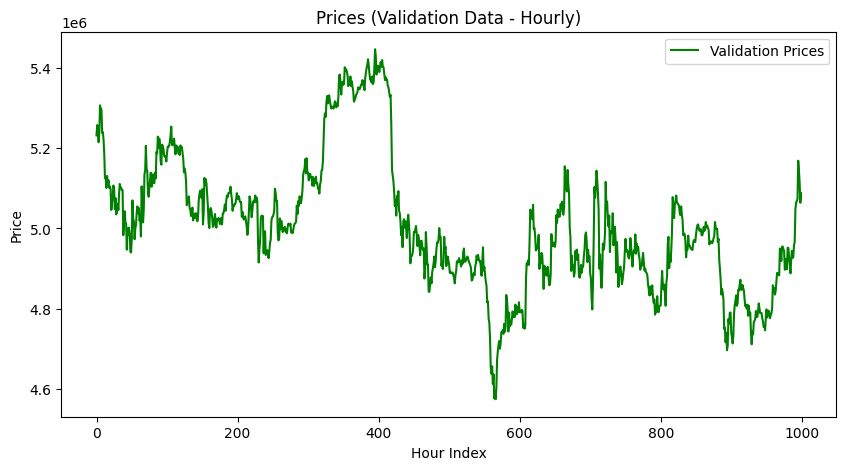

In [26]:

import matplotlib.pyplot as plt

def plot_validation_prices(validation_prices):
    """
    Plots the validation price series separately.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(validation_prices, color='green', label="Validation Prices")
    plt.title("Prices (Validation Data - Hourly)")
    plt.xlabel("Hour Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# ✅ Call this function after validation in a separate Jupyter Notebook cell
plot_validation_prices(validation_prices)


,Time Step,Action,Net Worth (KRW),Profit/Loss (KRW)
0,31,Buy,5.000000e+06,0.000000
1,32,Buy,4.985181e+06,-14819.205691
2,33,Buy,5.024699e+06,39517.881842
3,34,Buy,5.049397e+06,24698.676151
4,35,Sell,5.040506e+06,-8891.523414
5,36,Buy,5.040506e+06,0.000000
6,37,Sell,5.035565e+06,-4940.703616
7,38,Hold,5.035565e+06,0.000000
8,39,Buy,5.035565e+06,0.000000
9,40,Buy,5.067903e+06,32337.564521


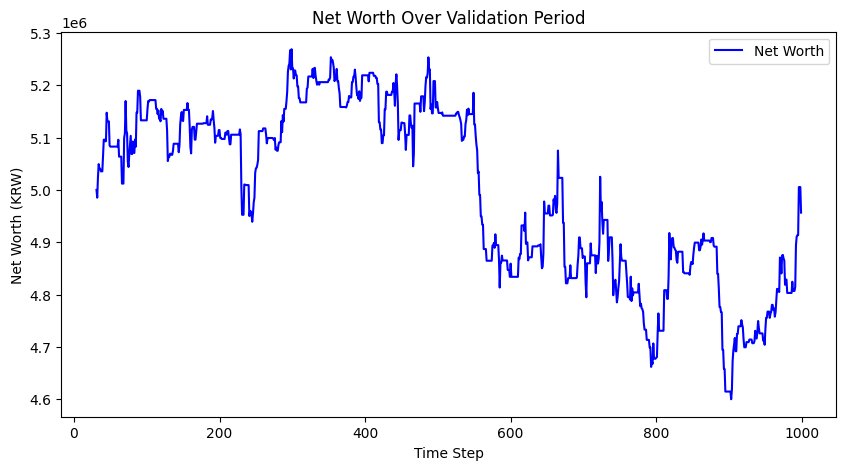

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_validation_results(validation_data):
    """
    Plots the net worth over time during validation and displays a table of decisions taken.
    """
    # Convert validation data to a Pandas DataFrame
    df = pd.DataFrame(validation_data)
    
    # Rename columns for clarity
    df.rename(columns={"hour_index": "Time Step", "action": "Action", "net_worth": "Net Worth (KRW)", "hourly_pnl": "Profit/Loss (KRW)"}, inplace=True)

    # Replace action values with labels
    action_map = {0: "Hold", 1: "Buy", 2: "Sell"}
    df["Action"] = df["Action"].map(action_map)
    
    # ✅ **Display as a table in Jupyter Notebook**
    from IPython.display import display
    display(df.head(50))  # Show first 50 steps (you can adjust this)
    
    # 📈 **Plot Net Worth over Time**
    plt.figure(figsize=(10, 5))
    plt.plot(df["Time Step"], df["Net Worth (KRW)"], label="Net Worth", color="blue")
    plt.xlabel("Time Step")
    plt.ylabel("Net Worth (KRW)")
    plt.title("Net Worth Over Validation Period")
    plt.legend()
    plt.show()

# ✅ Run this after validation
plot_validation_results(validation_data)
